# IC50 value regression with XGBoost

----

- Cross validation using the all data

- Using all observations (all species, </=/> values too)

- simple one-hot encoding scheme for all categorical variables (species, hla type/subtypes,sequence)

- This is the best i can do now



----

In [1]:
import os,sys

#load my functions
sys.path.append('../')
from utils import load_all_data,my_xgb_cv_predict,corr_plot

#go to working dir
work_dir='/data/data1/ribli/mhc/'
os.chdir(work_dir)

#plot embedding
%matplotlib inline

### Load data

In [3]:
x,y,_=load_all_data(hla_representation='one-hot',
    species_representation='one-hot',
    seq_representation='one-hot')

Reading from file...
Creating representation...
Using  137654  training data points
Using  27680  testing data points
Done, It took: 8.31665611267 s


### Train with cross validation

In [4]:
#model params
params = {'max_depth':20,
         'eta':0.05,
         'min_child_weight':5,
         'colsample_bytree':1,
         'subsample':1,
         'silent':1,
         'objective': "reg:linear",
         'eval_metric': 'rmse',
         'nthread':4}

y_pred=my_xgb_cv_predict(params,x,y,n_folds=5)

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-rmse:3.105757	eval-rmse:3.106300
[500]	train-rmse:0.401677	eval-rmse:0.746209
[1000]	train-rmse:0.289647	eval-rmse:0.733925
[1500]	train-rmse:0.226770	eval-rmse:0.732394
Stopping. Best iteration:
[1471]	train-rmse:0.229860	eval-rmse:0.732318

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-rmse:3.102007	eval-rmse:3.102313
[500]	train-rmse:0.404037	eval-rmse:0.761946
[1000]	train-rmse:0.286762	eval-rmse:0.750761
[1500]	train-rmse:0.224551	eval-rmse:0.749496
Stopping. Best iteration:
[1556]	train-rmse:0.218658	eval-rmse:0.749448

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-rmse:3.104419	eval-rmse:3.104778
[500]	train-rmse:0.400003	eval-rmse:0.762687
[1000]	train-rmse:0.291912	eval-rmse:0.751321
[1500]	train-rmse:0.231859	eval-rmse:0.749307
Stopping. Best iteration:
[1654]	train-rmse:0.215633	eval-rmse:0.748953

Will train until eval error hasn't decreased in 200 rounds.
[

### Plot correlation

Correlation: 0.830073327354


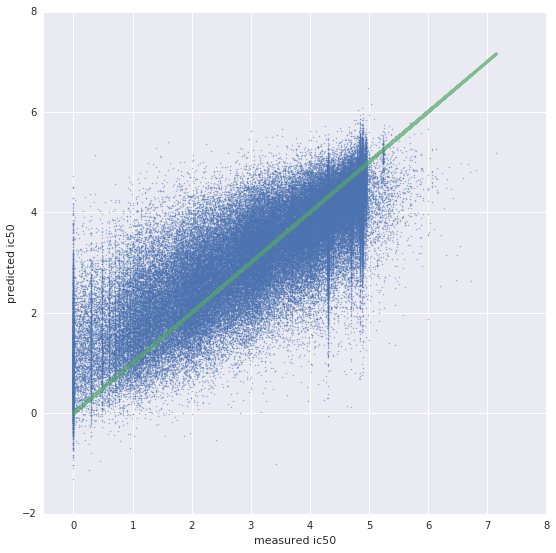

In [6]:
#from utils import corr_plot
corr_plot(y,y_pred)